<a href="https://colab.research.google.com/github/adamzbikowski/Process-Mining-Dissertation/blob/main/timestamp_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pipeline 1: predicting missing values for activity

##Section 0: Customisation

**Note on usage:**
To customise the pipeline, only alter the parameters in this section.

In [24]:
# The following parameters can be customised:

# change depending on which branch the queries have been pushed to
BRANCH = "sql-queries" 

# change this to change which query is being used
QUERY_NAME = "el_5.sql"

# this assumes that the user has access to the mimic-iii dataset
# through google BigQuery
# replace project name to the project containing mimic-iii
PROJECT_NAME = "processmining-367815" 

# change to alter the number of random traces being selected
# set value to None in order to use the full dataset
NUM_TRACES = 100

# IGNORE if event log does not include procedures
# set to false if  
CATEGORICAL_PROCEDURES = False

# change to alter the prefix/suffix length
PREFIX_LENGTH = 5

# change to alter the size of the test and validation sets
TEST_SIZE = 0.2
VALIDATION_SIZE = 0.2

# change to tune hyperparameters






## Section 1: Loading event log

###1.1

In [25]:
# installing prerequisites
# certain packages are not installed by default on google colab
!pip install pm4py
!pip install -q -U keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [26]:
from google.colab import auth
auth.authenticate_user()

In [27]:

from google.cloud import bigquery
client = bigquery.Client(project=PROJECT_NAME)

In [28]:
import requests

# read a query from the github repository
url = f"https://raw.githubusercontent.com/adamzbikowski/Process-Mining-Dissertation/{BRANCH}/sql_queries/{QUERY_NAME}"
query_bytes = requests.get(url).content

# we must now decode this to turn the query into a string 
query = query_bytes.decode("utf-8")

###1.2

In [29]:
import pandas as pd

# loading event log from mimic-iii using bigQuery
event_log = client.query(query).to_dataframe()
# convert timestamp from object to datetime64
event_log["timestamp"] = pd.to_datetime(event_log["timestamp"])
event_log


,patient,activity,timestamp
0,109129,Discharged,2188-08-01 12:04:00
1,121510,Discharged,2133-04-23 15:52:00
2,106469,Discharged,2109-02-23 12:01:00
3,133732,Discharged,2167-10-16 13:13:00
4,119601,Discharged,2198-02-20 15:33:00
...,...,...,...
230665,147635,Entered ICU,2124-11-22 21:55:59
230666,167802,Entered ICU,2200-02-26 18:40:12
230667,186391,Entered ICU,2134-01-08 21:59:39
230668,156213,Entered ICU,2107-02-05 17:16:52


## Section 2: Process Discovery

In [30]:
import pm4py as pm

event_log = pm.format_dataframe(event_log, case_id='patient', activity_key='activity', timestamp_key='timestamp')
# lets get some information about the event log
n_events = len(event_log)
n_cases = len(event_log.patient.unique())
start_events = pm.get_start_activities(event_log)
end_events = pm.get_end_activities(event_log)
print(f"Number of cases: {n_cases}\nNumber of events: {n_events}")
print(f"Start events: {start_events}\nEnd events: {end_events}")


<ipython-input-30-aedec179434f>:3: DeprecatedWarning: format_dataframe is deprecated as of 2.3.0 and will be removed in 3.0.0. the format_dataframe function does not need application anymore.
  event_log = pm.format_dataframe(event_log, case_id='patient', activity_key='activity', timestamp_key='timestamp')
/usr/local/lib/python3.9/dist-packages/pm4py/utils.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[constants.CASE_CONCEPT_NAME] = df[constants.CASE_CONCEPT_NAME].astype("string")
/usr/local/lib/python3.9/dist-packages/pm4py/utils.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.p

Number of cases: 42652
Number of events: 230668
Start events: {'Admitted': 36881, 'Transfer': 5716, 'Discharged': 55}
End events: {'Discharged': 34688, 'Left ICU': 7947, 'Transfer': 14, 'Admitted': 3}


In [31]:
# lets improve the event log by filtering out the cases that do not start or end with a patient being admitted or discharged
# this will simplify the model
# filtered_log = deepcopy(event_log)
event_log = pm.filter_start_activities(event_log, ['Admitted'])
event_log = pm.filter_end_activities(event_log,['Discharged'])
# event_log = pm.filter_variants_top_k(event_log,50)
# event_log = pm.filter_variants_by_coverage_percentage(event_log, 0.1)

In [32]:
n_events = len(event_log)
n_cases = len(event_log.patient.unique())
start_events = pm.get_start_activities(event_log)
end_events = pm.get_end_activities(event_log)
print(f"Number of cases: {n_cases}\nNumber of events: {n_events}")
print(f"Start events: {start_events}\nEnd events: {end_events}")

Number of cases: 29340
Number of events: 160233
Start events: {'Admitted': 29340}
End events: {'Discharged': 29340}


In [33]:
net, initial_marking, final_marking = pm.discover_petri_net_alpha(event_log)

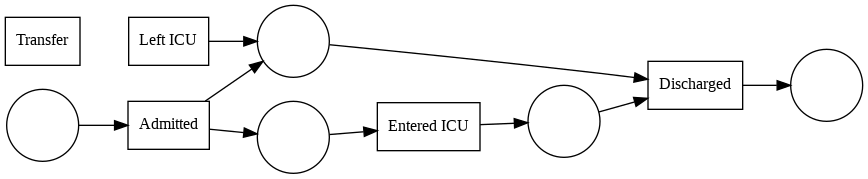

In [34]:
import graphviz
pm.view_petri_net(petri_net=net)

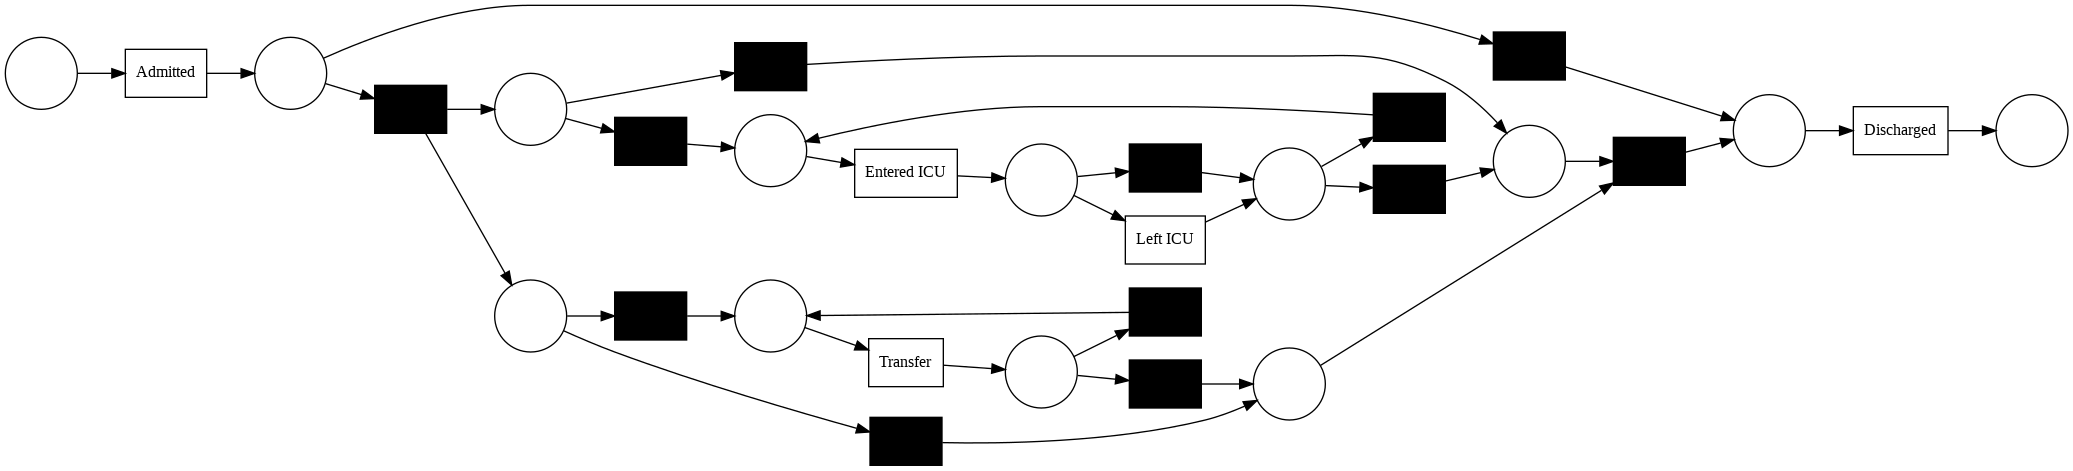

In [35]:
# inductive miner
# much better result than when using alpha miner, petri net 
net, initial_marking, final_marking = pm.discover_petri_net_inductive(event_log)
pm.view_petri_net(petri_net=net)

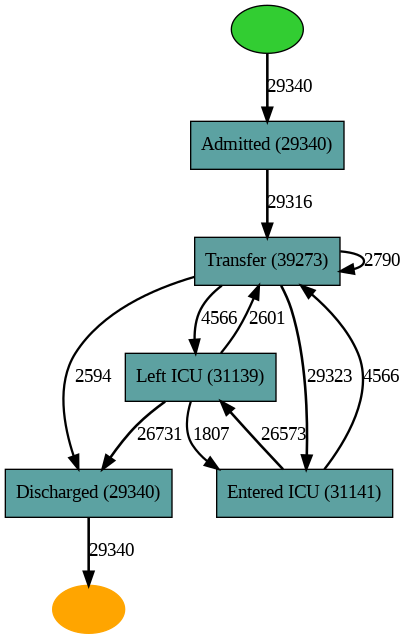

In [36]:
# heuristic miner
heu_net = pm.discover_heuristics_net(event_log, dependency_threshold=0.99)
pm.view_heuristics_net(heu_net)

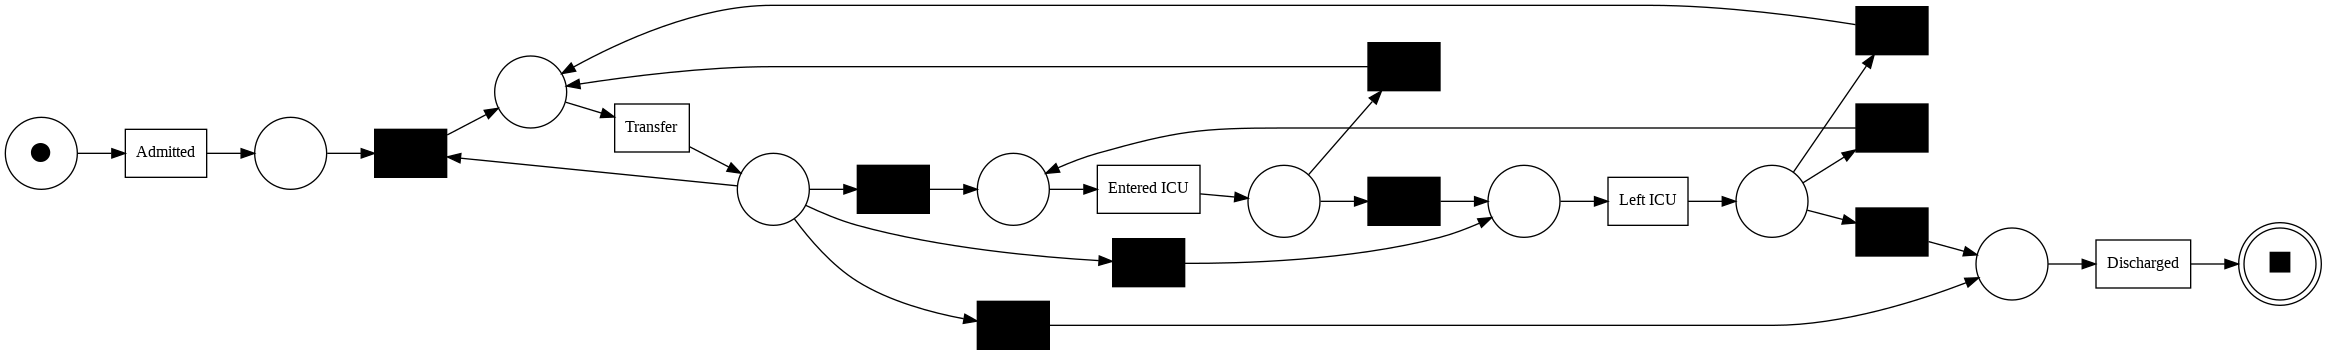

In [37]:
# petri net from heuristics miner
net, im, fm = pm.discover_petri_net_heuristics(event_log, dependency_threshold=0.99)
pm.view_petri_net(net, im, fm)

##Section 3: Preprocessing Data

In [38]:
from pandas.core.window.ewm import partial
import random

def partial_log(el, n):

  # select the first n cases to test the LSTM methodology
  # lets first add a trace column to the event_log
  el['trace'] = el.groupby(['patient']).ngroup()
  el = el[['trace', 'activity', 'timestamp' ]].reset_index(drop=True)
  # if n is None, return full event log
  if n is None:
    return el

  # initialise random seed and array of traces
  # random.seed(9)
  random_traces = []

  for i in range(0,n):
    random_traces.append(random.randrange(0,n_cases))

  partial_el = el[el['trace'].isin(random_traces)]
  return partial_el


In [39]:
partial_el = partial_log(event_log, NUM_TRACES)
partial_el

,trace,activity,timestamp
728,132,Admitted,2162-06-23 21:54:00
729,132,Transfer,2162-06-23 21:55:08
730,132,Entered ICU,2162-06-23 21:55:08
731,132,Transfer,2162-06-24 19:35:57
732,132,Left ICU,2162-07-08 17:51:46
...,...,...,...
157937,28924,Transfer,2183-01-07 17:09:10
157938,28924,Entered ICU,2183-01-24 16:47:24
157939,28924,Transfer,2183-01-24 17:05:14
157940,28924,Left ICU,2183-02-02 14:45:31


In [40]:
# lets represent each activity using a statically defined number
# this will prevent the need for using an embedding layer when traing the LSTM
unique_activities = partial_el['activity'].unique()
n_activities = len(unique_activities) + 1
encode_activity = {unique_activities[i-1] : f'{i}' for i in range(1,n_activities)}

# lets also create a second dictionary that will be used to decode predicted activities
decode_activity = {f'{i}' : unique_activities[i-1] for i in range(1, len(unique_activities)+ 1)}
encode_activity, decode_activity

({'Admitted': '1',
  'Transfer': '2',
  'Entered ICU': '3',
  'Left ICU': '4',
  'Discharged': '5'},
 {'1': 'Admitted',
  '2': 'Transfer',
  '3': 'Entered ICU',
  '4': 'Left ICU',
  '5': 'Discharged'})

In [41]:
from sklearn.model_selection import train_test_split
# select train and test traces
unique_traces = partial_el['trace'].unique()
train_traces, test_traces = train_test_split(unique_traces, test_size=TEST_SIZE, random_state=9)

train_el = partial_el.loc[partial_el['trace'].isin(train_traces)]
test_el = partial_el.loc[partial_el['trace'].isin(test_traces)]
test_el

,trace,activity,timestamp
3834,697,Admitted,2180-10-06 20:07:00
3835,697,Transfer,2180-10-06 20:09:47
3836,697,Entered ICU,2180-10-06 20:09:47
3837,697,Left ICU,2180-10-28 18:35:53
3838,697,Discharged,2180-11-08 14:40:00
...,...,...,...
152335,27895,Transfer,2200-12-03 11:48:49
152336,27895,Entered ICU,2200-12-08 10:45:38
152337,27895,Transfer,2200-12-08 13:48:08
152338,27895,Left ICU,2200-12-10 21:13:26


In [43]:
import numpy as np

# transform train data into prefix, suffix and label
def label_train(el):
  prefix_arr, suffix_arr, prefix_times_arr, suffix_times_arr, label_arr, label_times_arr = [], [], [], [], [], []
  labeled_arr = []
  unique_traces = el['trace'].unique()
  
  for t in unique_traces:
    df = el[:][el.trace == t].sort_values(by='timestamp')
    activities, timestamps = [], []

    for i in df.index:
      activity = encode_activity.get(df['activity'][i])
      activities.append(activity)

      timestamp = df['timestamp'][i].value
      timestamps.append(timestamp)
    
    length = len(activities)
    
    for i in range(length):
      label = activities[i]
      time_label = timestamps[i]
      prefix = activities[:i]
      prefix_times = timestamps[:i]

      suffix = []
      suffix_times = []

      if i != length - 1:
        suffix = activities[i+1:]
        suffix_times = timestamps[i+1:]

      padding = []

      while len(prefix) + len(padding) < PREFIX_LENGTH:
        padding.append('0')
      
      prefix = padding + prefix
        
      padding = []
      
      while len(prefix_times) + len(padding) < PREFIX_LENGTH:
        padding.append('0')
      
      prefix_times =  padding + prefix_times

      while len(suffix) < PREFIX_LENGTH:
        suffix.append('0')

      while len(suffix_times) < PREFIX_LENGTH:
        suffix_times.append('0')
      
      prefix_arr.append(np.array(prefix[0:PREFIX_LENGTH], dtype=int))
      suffix_arr.append(np.array(suffix[0:PREFIX_LENGTH], dtype=int))
      prefix_times_arr.append(np.array(prefix_times))
      suffix_times_arr.append(np.array(suffix_times))
      label_arr.append(label)
      label_times_arr.append(time_label)

  return pd.DataFrame({'prefix' : prefix_arr, 
                       'suffix' : suffix_arr,
                       'prefix time delta' : prefix_times_arr,
                       'suffix time delta' : suffix_times_arr,
                       'activity label' : label_arr,
                       'time label': label_times_arr})
  

labeled_train_el = label_train(train_el)
labeled_train_el

,prefix,suffix,prefix time delta,suffix time delta,activity label,time label
0,"[0, 0, 0, 0, 0]","[2, 3, 2, 4, 5]","[0, 0, 0, 0, 0]","[6073998908000000000, 6073998908000000000, 607...",1,6073998840000000000
1,"[0, 0, 0, 0, 1]","[3, 2, 4, 5, 0]","[0, 0, 0, 0, 6073998840000000000]","[6073998908000000000, 6074076957000000000, 607...",2,6073998908000000000
2,"[0, 0, 0, 1, 2]","[2, 4, 5, 0, 0]","[0, 0, 0, 6073998840000000000, 607399890800000...","[6074076957000000000, 6075280306000000000, 607...",3,6073998908000000000
3,"[0, 0, 1, 2, 3]","[4, 5, 0, 0, 0]","[0, 0, 6073998840000000000, 607399890800000000...","[6075280306000000000, 6075778800000000000, 0, ...",2,6074076957000000000
4,"[0, 1, 2, 3, 2]","[5, 0, 0, 0, 0]","[0, 6073998840000000000, 6073998908000000000, ...","[6075778800000000000, 0, 0, 0, 0]",4,6075280306000000000
...,...,...,...,...,...,...
422,"[0, 0, 0, 0, 1]","[3, 2, 4, 5, 0]","[0, 0, 0, 0, 6722240880000000000]","[6723708444000000000, 6723709514000000000, 672...",2,6722240950000000000
423,"[0, 0, 0, 1, 2]","[2, 4, 5, 0, 0]","[0, 0, 0, 6722240880000000000, 672224095000000...","[6723709514000000000, 6724478731000000000, 672...",3,6723708444000000000
424,"[0, 0, 1, 2, 3]","[4, 5, 0, 0, 0]","[0, 0, 6722240880000000000, 672224095000000000...","[6724478731000000000, 6725499420000000000, 0, ...",2,6723709514000000000
425,"[0, 1, 2, 3, 2]","[5, 0, 0, 0, 0]","[0, 6722240880000000000, 6722240950000000000, ...","[6725499420000000000, 0, 0, 0, 0]",4,6724478731000000000


In [44]:
from copy import deepcopy

def random_remove(el):
  unique_traces_test = el['trace'].unique()
  traces = {x : pd.DataFrame() for x in unique_traces_test}
  df = pd.DataFrame(columns=['trace', 'activity', 'timestamp'])
  random.seed = (9)
  targets = []

  for t in unique_traces_test:
    traces[t] = deepcopy(test_el[:][test_el.trace == t])
    trace_df = traces[t].sort_values(by='timestamp')
    rand_index = random.randrange(0,len(trace_df.index))
    targets.append(trace_df.iat[rand_index,2])
    trace_df.iat[rand_index, 2] = np.nan
    df = pd.concat([df, trace_df])

  return df, targets

In [45]:
test_x, test_y = random_remove(test_el)
test_x

,trace,activity,timestamp
3834,697,Admitted,2180-10-06 20:07:00
3835,697,Transfer,2180-10-06 20:09:47
3836,697,Entered ICU,2180-10-06 20:09:47
3837,697,Left ICU,2180-10-28 18:35:53
3838,697,Discharged,NaT
...,...,...,...
152335,27895,Transfer,2200-12-03 11:48:49
152336,27895,Entered ICU,2200-12-08 10:45:38
152337,27895,Transfer,NaT
152338,27895,Left ICU,2200-12-10 21:13:26


##Section 4: Predicting the correct sequence order

###4.1 Creating process model using training set

<ipython-input-46-ac7a42cbc91e>:2: DeprecatedWarning: format_dataframe is deprecated as of 2.3.0 and will be removed in 3.0.0. the format_dataframe function does not need application anymore.
  train_log = pm.format_dataframe(train_el, case_id='trace', activity_key='activity', timestamp_key='timestamp')
/usr/local/lib/python3.9/dist-packages/pm4py/utils.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[constants.CASE_CONCEPT_NAME] = df[case_id]
/usr/local/lib/python3.9/dist-packages/pm4py/utils.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

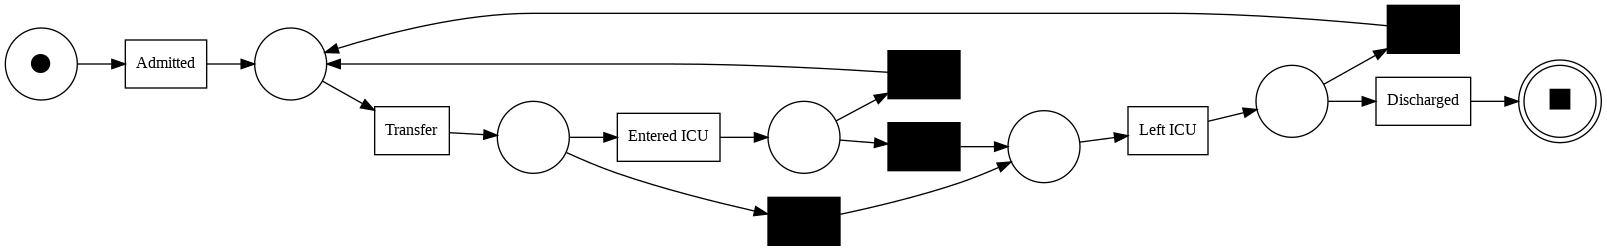

In [46]:
# format train event log as pm4py event log
train_log = pm.format_dataframe(train_el, case_id='trace', activity_key='activity', timestamp_key='timestamp')
# petri net from heuristics miner
heuristic_net, heuristic_im, heuristic_fm = pm.discover_petri_net_heuristics(train_log, dependency_threshold=0.985)
pm.view_petri_net(heuristic_net, heuristic_im, heuristic_fm)

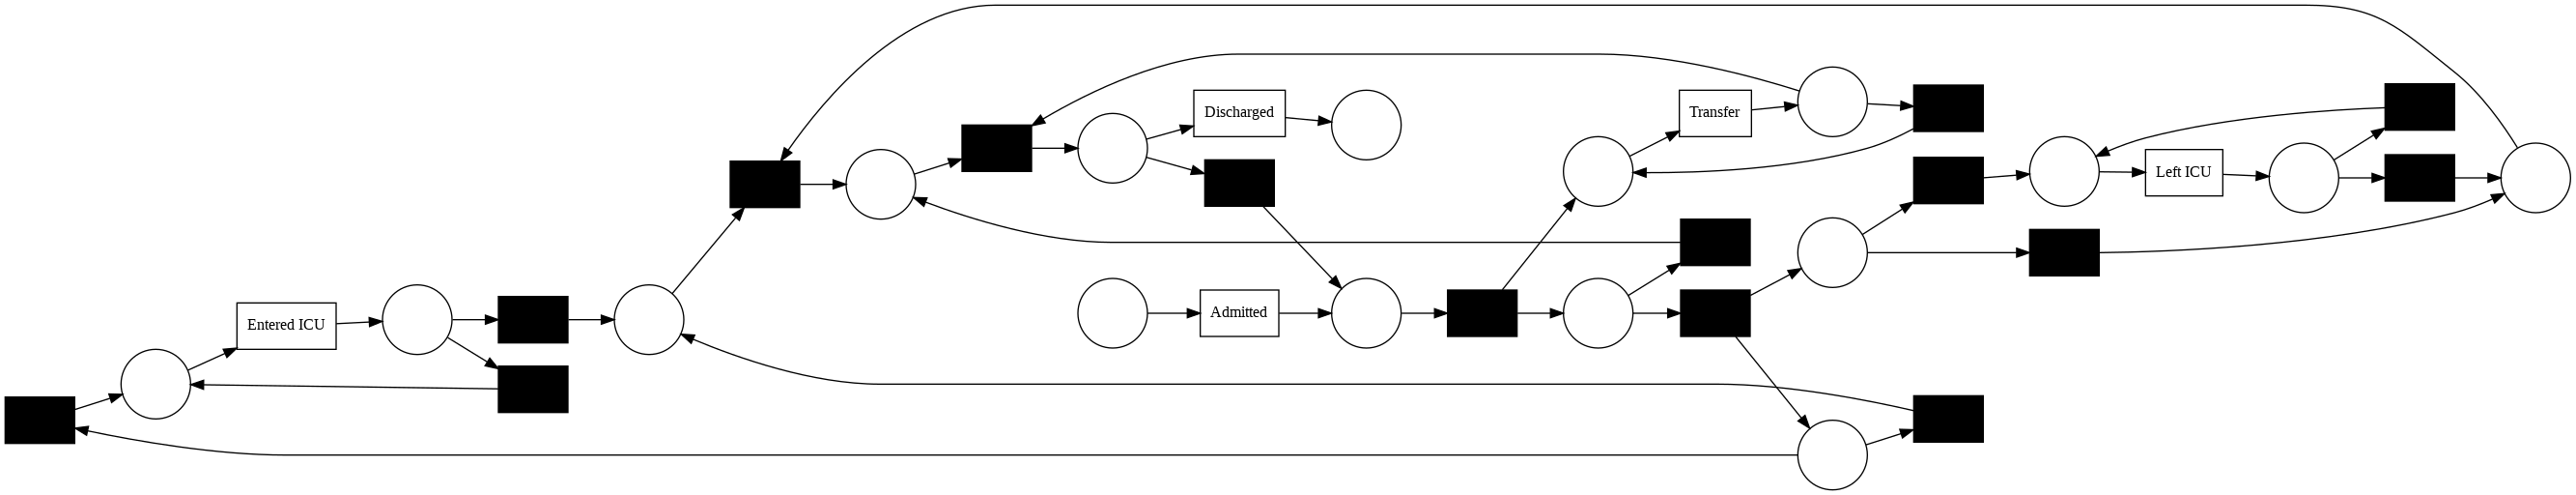

In [47]:
inductive_net, inductive_im, inductive_fm = pm.discover_petri_net_inductive(train_log)
pm.view_petri_net(petri_net=inductive_net)

###4.2

In [48]:
def replay_trace(el):
  # log = pm.format_dataframe(el, case_id='trace', activity_key='activity', timestamp_key='timestamp')
  replay_result = pm.fitness_token_based_replay(el, heuristic_net, heuristic_im, heuristic_fm, case_id_key='trace', activity_key='activity', timestamp_key='timestamp')
  return replay_result['average_trace_fitness']

In [49]:
def generate_traces(sequence, missing, trace):
    timestamps = sequence['timestamp'].tolist()
    if missing.iat[0,1] == 'Admitted':
      return pd.concat([missing,sequence], ignore_index=True)
    if missing.iat[0,1] == 'Discharged':
      return pd.concat([sequence,missing], ignore_index=True)
     
    trace_length = len(timestamps) -1
    best_fitness = 0
    best_trace = None
    for i in range(1,trace_length):
      df = pd.concat([sequence.head(i), missing, sequence.tail(trace_length-i)], ignore_index=True)
      inputed_df = deepcopy(df)
      previous_timestamp = inputed_df.iat[i-1,2]
      next_timestamp = inputed_df.iat[i+1,2]
      inputed_timestamp = previous_timestamp + (next_timestamp-previous_timestamp)/2 
      inputed_df.iat[i,2] = inputed_timestamp
      fitness = replay_trace(inputed_df)
      fitness = 1
      if fitness > best_fitness:
        best_fitness = fitness
        best_trace = df

    return best_trace


In [50]:
def predict_sequences(el):
  df = pd.DataFrame(columns=['trace','activity','timestamp'])
  unique_traces = el['trace'].unique()

  for t in unique_traces:
    trace_df = el[:][test_el.trace == t]
    sequence = trace_df.loc[trace_df['timestamp'].notna()]
    missing = trace_df.loc[trace_df['timestamp'].isna()]
 
    predicted_trace = generate_traces(sequence, missing, t)
    df = pd.concat([df,predicted_trace], ignore_index=True)

  return df

test_sequences = predict_sequences(test_x)


In [82]:
def label_test(el):
  prefix_arr, suffix_arr, prefix_times_arr, suffix_times_arr, label_arr, label_times_arr = [], [], [], [], [], []
  labeled_arr = []
  unique_traces = el['trace'].unique()

  for t in unique_traces:
    df = el[:][el.trace == t]
    activities, timestamps = [], []

    for i in df.index:
      activity = encode_activity.get(df['activity'][i])
      activities.append(activity)

      timestamp = df['timestamp'][i]
      timestamps.append(timestamp)
    
    length = len(timestamps)
    order = 0
    for i in range(length):
      if pd.isnull(timestamps[i]):
        order = i
        break

    label = activities[order]
    time_label = timestamps[order]
    prefix = activities[:order]
    prefix_times = timestamps[:order]

    suffix, suffix_times = [], []

    if i != length - 1:
      suffix = activities[i+1:]
      suffix_times = timestamps[i+1:]

    padding = []

    while len(prefix) + len(padding) < PREFIX_LENGTH:
      padding.append('0')
    
    prefix = padding + prefix
      
    padding = []
    
    while len(prefix_times) + len(padding) < PREFIX_LENGTH:
      padding.append('0')
    
    prefix_times =  padding + prefix_times

    while len(suffix) < PREFIX_LENGTH:
      suffix.append('0')

    while len(suffix_times) < PREFIX_LENGTH:
      suffix_times.append('0')

    f = '%Y-%d-%m %H:%M:%S'
    for i in range(PREFIX_LENGTH):
      try:
        prefix_times[i] = pd.to_datetime(prefix_times[i], format=f).value
        # suffix_times[i] = pd.to_datetime(suffix_times[i], format=f).value
      except ValueError:
        continue

    for i in range(PREFIX_LENGTH):
      try:
        # prefix_times[i] = pd.to_datetime(prefix_times[i], format=f).value
        suffix_times[i] = pd.to_datetime(suffix_times[i], format=f).value
      except ValueError:
        continue

    prefix_arr.append(np.array(prefix[0:PREFIX_LENGTH], dtype=int))
    suffix_arr.append(np.array(suffix[0:PREFIX_LENGTH], dtype=int))
    prefix_times_arr.append(np.array(prefix_times[:5]))
    suffix_times_arr.append(np.array(suffix_times[:5]))
    label_arr.append(label)
    label_times_arr.append(time_label)

  return pd.DataFrame({'prefix' : prefix_arr, 
                       'suffix' : suffix_arr,
                       'prefix time delta' : prefix_times_arr,
                       'suffix time delta' : suffix_times_arr,
                       'activity label' : label_arr,
                       'timestamp label': label_times_arr})


In [83]:
label_test(test_sequences)

,prefix,suffix,prefix time delta,suffix time delta,activity label,timestamp label
0,"[0, 1, 2, 3, 4]","[0, 0, 0, 0, 0]","[0, 6651144420000000000, 6651144587000000000, ...","[0, 0, 0, 0, 0]",5,NaT
1,"[0, 0, 0, 0, 0]","[2, 3, 4, 5, 0]","[0, 0, 0, 0, 0]","[5823178431000000000, 5823178431000000000, 582...",1,NaT
2,"[0, 0, 0, 0, 1]","[3, 4, 5, 0, 0]","[0, 0, 0, 0, 5609862240000000000]","[5609862300000000000, 5609915640000000000, 561...",2,NaT
3,"[0, 0, 0, 0, 0]","[2, 3, 4, 5, 0]","[0, 0, 0, 0, 0]","[5342692927000000000, 5342692927000000000, 534...",1,NaT
4,"[0, 0, 0, 0, 1]","[3, 5, 0, 0, 0]","[0, 0, 0, 0, 5129893320000000000]","[5129893380000000000, 5130321360000000000, 0, ...",4,NaT
5,"[0, 0, 0, 0, 0]","[2, 3, 4, 2, 3]","[0, 0, 0, 0, 0]","[6605689180000000000, 6606210798000000000, 660...",1,NaT
6,"[0, 0, 0, 0, 0]","[2, 3, 4, 5, 0]","[0, 0, 0, 0, 0]","[4852915598000000000, 4853388318000000000, 485...",1,NaT
7,"[0, 0, 0, 0, 1]","[3, 2, 5, 0, 0]","[0, 0, 0, 0, 5330531340000000000]","[5330531505000000000, 5331172793000000000, 533...",4,NaT
8,"[0, 1, 2, 3, 4]","[0, 0, 0, 0, 0]","[0, 5321980560000000000, 5321980616000000000, ...","[0, 0, 0, 0, 0]",5,NaT
9,"[0, 0, 0, 0, 1]","[4, 3, 4, 5, 0]","[0, 0, 0, 0, 5077286580000000000]","[5077347390000000000, 5077453761000000000, 507...",3,NaT


## Section 5: Predicting timestamp using LSTM 